In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# library for creating data paths
import os

# library for randonly selecting data points
import random

# library for performing numerical computations
import numpy as np

# library for creating and showing plots
import matplotlib.pyplot as plt

# library for reading and showing images
import matplotlib.image as mpimg

# importing all the required sub-modules from keras
from tensorflow.keras.optimizers import Adam  #can use adam_v2 too, from keras.optimizer import adam_v2
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model    #Model for Transfer learning
from keras.applications.vgg16 import VGG16    # Transfer learning here too (AGV comments),
from keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator  #For data augmentation
from keras.preprocessing.image import img_to_array, load_img  # to load images into arrays
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [9]:
# parent directory where images are stored in drive, careful how you build this
parent_dir = '/content/drive/MyDrive/Colab Notebooks/cnn_assignment/chest_xray'

# path to the training and validation datasets within the parent directory
train_dir = os.path.join(parent_dir, 'train')
validation_dir = os.path.join(parent_dir, 'val')

# directory with our training nom/pne pictures
train_nom_dir = os.path.join(train_dir, 'NORMAL')
train_pne_dir = os.path.join(train_dir, 'PNEUMONIA')

# directory with our validation nom/pne pictures
validation_nom_dir = os.path.join(validation_dir, 'NORMAL')
validation_pne_dir = os.path.join(validation_dir, 'PNEUMONIA')

In [4]:
import cv2
from google.colab.patches import cv2_imshow

Normal (1858, 2090, 3)
PNEUMONIA (1056, 1448, 3)


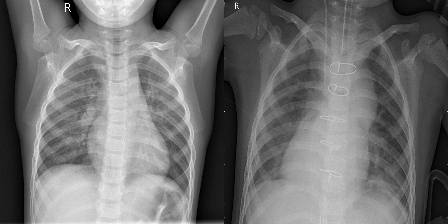

In [7]:
#View some of the images from train & val
n1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/cnn_assignment/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
print ('Normal', n1.shape)
p1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/cnn_assignment/chest_xray/train/PNEUMONIA/person2_bacteria_3.jpeg')
print ('PNEUMONIA',p1.shape)
Hori = np.concatenate((cv2.resize(n1,(224,224)), cv2.resize(p1,(224,224))), axis=1)
cv2_imshow(Hori)

In [10]:
#Now lets Re shape! lets build the data generator
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1. / 255.0,zoom_range=0.1)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)
# Flowing training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,        #Dynamically runs every time, where to write them
                                                    batch_size=20,
                                                    class_mode='binary',     #two folders, one per class
                                                    target_size=(224, 224),
                                                    color_mode = 'rgb')     #Reshaping for this format

# Flowing validation images in batches of 20 images using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,  #location of the images, this is dynamic, changes on each run
                                                         batch_size=20,
                                                         class_mode  = 'binary',  #We have TWO folders, one per each class
                                                         target_size = (224, 224),
                                                         color_mode = 'rgb')

test_dir = os.path.join(parent_dir, 'test')

test_generator =  test_datagen.flow_from_directory(test_dir,  #location of the images, this is dynamic, changes on each run
                                                         batch_size=32,
                                                         class_mode  = 'binary',  #We have TWO folders, one per each class
                                                         target_size = (224, 224),
                                                         color_mode='rgb')

Found 5230 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


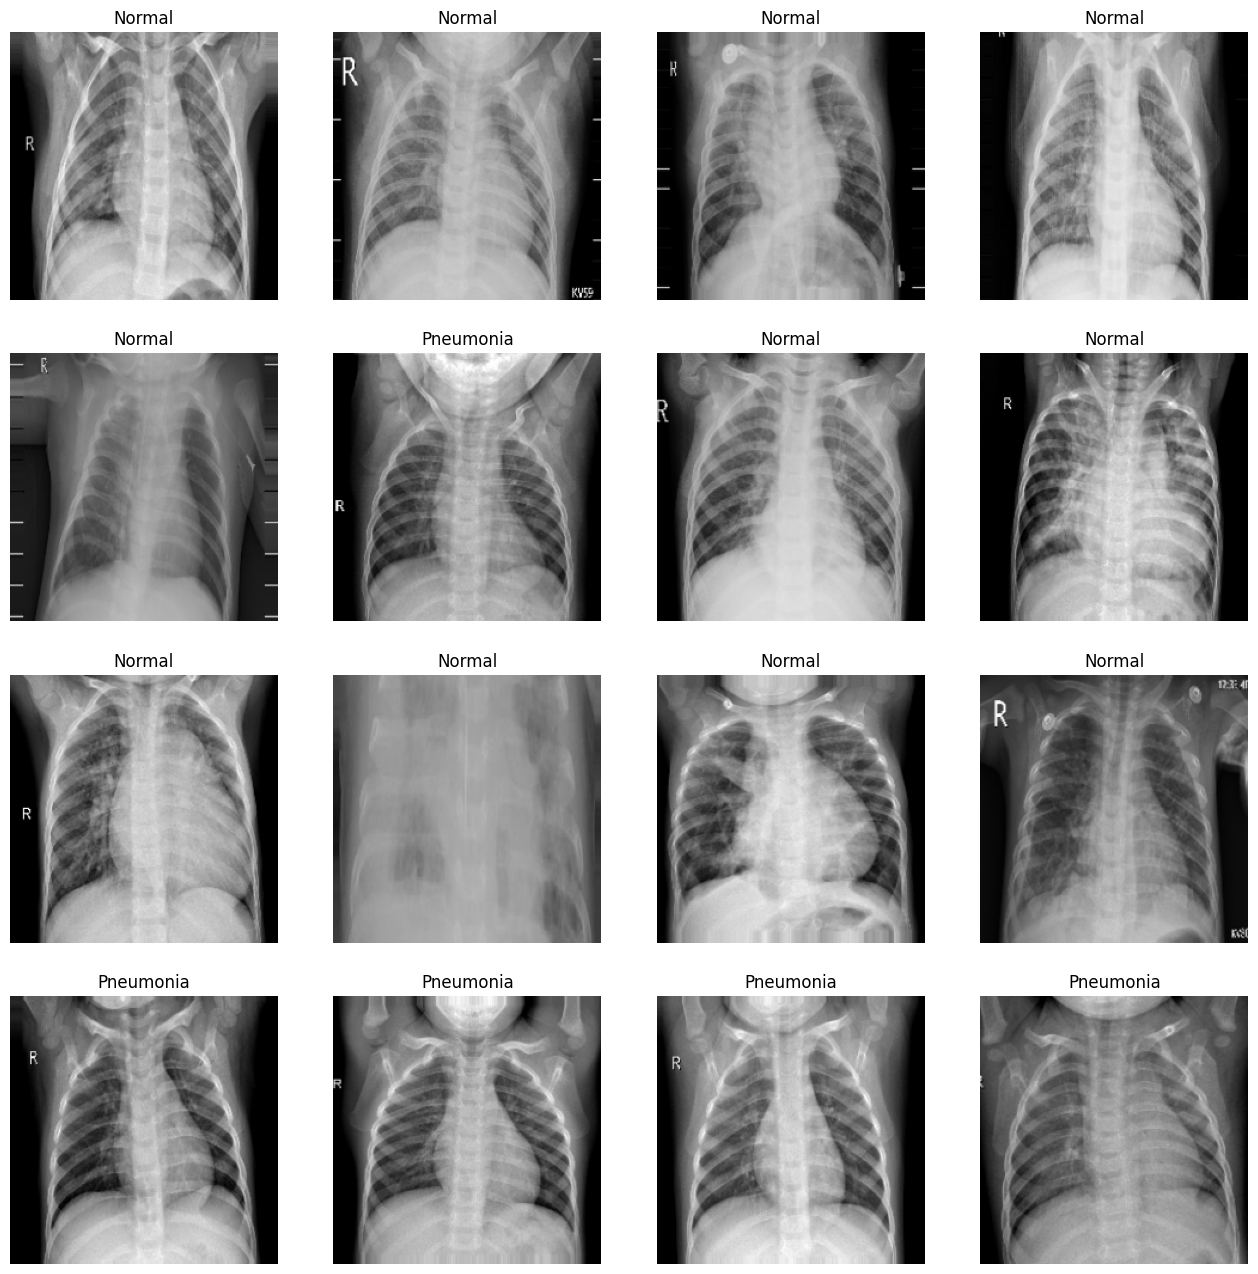

In [11]:
images, labels = next(train_generator) #generator function, dynamically generates new data (20 images) after the next
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):    #the labels because of the name of the folders, normal and pneumonia folders
    ax.imshow(image)
    if label == 1:
        ax.set_title('Normal')
    else:
        ax.set_title('Pneumonia')
    ax.axis('off')

In [12]:
#We are building a simple CNN model, we use Sigmoid because it is only two categories, binary classification. No transfer learning yet.
cnn_model = Sequential()
cnn_model.add(Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(32, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))  #Fully connected layer
cnn_model.add(Dense(1, activation='sigmoid'))  #binary classification
cnn_model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      22,151,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,175,777 (84.59 MB)

 Trainable params: 22,175,777 (84.59 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
## pulling a single large batch of random validation data for testing after each epoch
testX, testY = validation_generator.__next__()
#20 samples for validation

In [16]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [17]:
model_history = cnn_model.fit(train_generator,
                                  validation_data=(testX, testY),   #20 samples for validation
                                  callbacks=[stop_early],
                                  epochs=3)  #limit the number of epochs to run faster only, as a demo

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 1236s 4s/step - accuracy: 0.7848 - loss: 0.6041 - val_accuracy: 0.9375 - val_loss: 0.3359
Epoch 2/3
262/262 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - accuracy: 0.9306 - loss: 0.1835 - val_accuracy: 0.8125 - val_loss: 0.3102
Epoch 3/3
262/262 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.9463 - loss: 0.1377 - val_accuracy: 0.6250 - val_loss: 0.8848


In [18]:
from statistics import mean
print("Avg. accuracy before Transfer Learning is",mean(model_history.history["val_accuracy"]))
print("Avg. loss before Transfer Learning is",mean(model_history.history["val_loss"]))
print ("Model",cnn_model.evaluate(test_generator))

Avg. accuracy before Transfer Learning is 0.7916666666666666
Avg. loss before Transfer Learning is 0.5102929770946503
20/20 ━━━━━━━━━━━━━━━━━━━━ 161s 8s/step - accuracy: 0.8227 - loss: 0.6577
Model [0.7438735961914062, 0.7964743375778198]


In [19]:
# Now we are building a model using the concepts of transfer learning.
#We will be loading pre-built architecture VGG16 which is trained on imagenet dataset.
# And then we will freeze the weights of first few initial layers and train only the last layers using our own data.
# Below is a schematic of the VGG16 model -

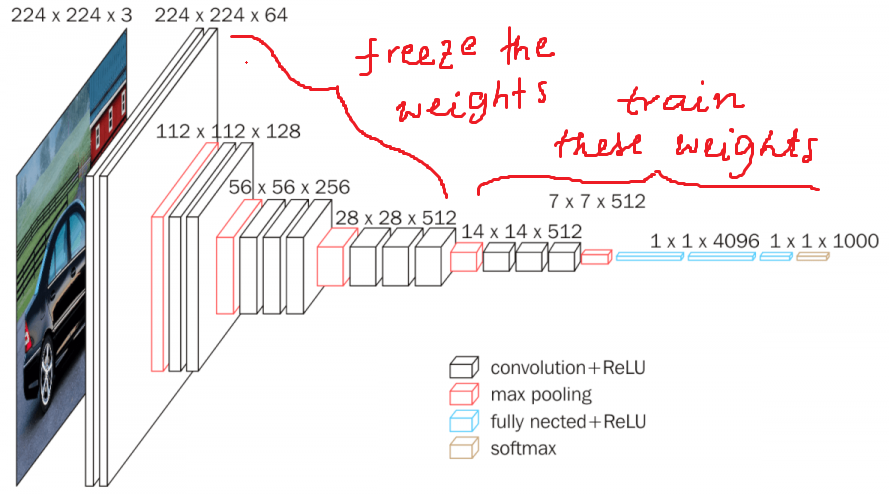

In [20]:
#This is the most important part. Transfer learning concept. with a model previously trained on imagenet data.
model = VGG16(include_top=True, weights='imagenet')   #To include top/input layer, importing the model. Includes input layer
model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
#We need to indicate, until what layer (from top to down) we want to make the transfer.
transfer_layer = model.get_layer('block5_pool')  #From top to block5_pool, funtion to import the layers, and apply the transfer layers
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)  #From these layers I am creating a new model. Feature extracted part.
#how to build the model, call the model Model function, input used

In [22]:
vgg_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#We have to say which layers we want to train, and which ones to mantain fix.
# we will choose which layers of VGG16 we actually want to fine-tune. Here we'll freeze all but the last convolutional layer
for layer in vgg_model.layers[0:17]:  #We are saying from layer 0 to 17
    layer.trainable = False    #Every layer has this trainable parameter, by default is True,

In [24]:
for layer in vgg_model.layers:  #loop to check
    print(layer.name, layer.trainable)  # name only if it is trainable or not. With the name we can specify which layer to Train.
    # Useful if we want to indicate what part to exclude on our training

input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [25]:
new_model = Sequential()  #we are building a sequential model

# adding the convolutional part of the VGG16 model from above. And thats all!
new_model.add(vgg_model)

# flattening the output of the VGG16 model because it is from a convolutional layer.
new_model.add(Flatten())   #We were doing the flatten in the previous steps

# adding a dense output layer. We can add more layers before, can use Relu too (in the previous one)
new_model.add(Dense(1, activation='sigmoid'))

#This part is very important to understand since it is the logic behind

In [26]:
# setting optimizer, loss function, and learning rate. Optimizing layer
optimizer = Adam(learning_rate=1e-4)
loss = 'binary_crossentropy'
metrics = ['accuracy']

In [27]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [28]:
new_model.summary()  #metrics, we have a functional layer

ValueError: Undefined shapes are not supported.

In [ ]:
## fitting the model
new_model_history = new_model.fit(train_generator,
                                  validation_data=(testX, testY),
                                  callbacks=[stop_early],   #This could reduce the number of epochs
                                  #steps_per_epoch=100,  #this needs to be at least equal to the number of Batch size. At least 100
                                  epochs=3)

Epoch 1/3


In [ ]:
print("Avg. accuracy before Transfer Learning is",mean(new_model_history.history["val_accuracy"]))
print("Avg. loss before Transfer Learning is",mean(new_model_history.history["val_loss"]))
print ("Model",new_model.evaluate(test_generator))

In [ ]:
# function to plot loss, val_loss,
def plot_history(history):
    N = len(history.history["loss"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Training Loss Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(bbox_to_anchor =(1.0, 0.5),loc='center left')

In [ ]:
# plotting the loss vs epoch curve for basic CNN model without transfer learning
plot_history(model_history)

In [ ]:
# plotting the loss vs epoch curve for basic CNN model wit transfer learning
plot_history(new_model_history)

Complete New Model

In [ ]:
# function to plot accuracy, val_accuracy,
def acc_plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor =(1.0,0.5),loc='center left')

In [ ]:
acc_plot_history(model_history)

In [ ]:
acc_plot_history(new_model_history)

In [ ]:
# Model with different parameters
cnn_model_1 = Sequential()
cnn_model_1.add(Conv2D(16, (3,3), activation='tanh', input_shape=(224, 224, 3)))
cnn_model_1.add(MaxPooling2D(2,2))
cnn_model_1.add(Conv2D(32, (3,3), activation='tanh'))
cnn_model_1.add(MaxPooling2D(2,2))
cnn_model_1.add(Conv2D(64, (3,3), activation='tanh'))
cnn_model_1.add(MaxPooling2D(2,2))
cnn_model_1.add(Flatten())
cnn_model_1.add(Dense(512, activation='tanh'))  #Fully connected layer
cnn_model_1.add(Dense(1, activation='sigmoid'))  #binary classification
#adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
cnn_model_1.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ['accuracy'])

In [ ]:
cnn_model_1.summary()

In [ ]:
model_history_1 = cnn_model_1.fit(train_generator,
                                  validation_data=(testX, testY),   #20 samples for validation
                                  callbacks=[stop_early],
                                  epochs=3)

In [ ]:
print("Avg. accuracy before Transfer Learning is",mean(model_history_1.history["val_accuracy"]))
print("Avg. loss before Transfer Learning is",mean(model_history_1.history["val_loss"]))

In [ ]:
plot_history(model_history_1)
acc_plot_history(model_history_1)

In [ ]:
# Tanh , RMSPROP
cnn_model_2 = Sequential()
cnn_model_2.add(Conv2D(16, (3,3), activation='tanh', input_shape=(224, 224, 3)))
cnn_model_2.add(MaxPooling2D(2,2))
cnn_model_2.add(Conv2D(32, (3,3), activation='tanh'))
cnn_model_2.add(MaxPooling2D(2,2))
cnn_model_2.add(Conv2D(64, (3,3), activation='tanh'))
cnn_model_2.add(MaxPooling2D(2,2))
cnn_model_2.add(Flatten())
cnn_model_2.add(Dense(512, activation='tanh'))  #Fully connected layer
cnn_model_2.add(Dense(1, activation='sigmoid'))  #binary classification

cnn_model_2.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics = ['accuracy'])

In [ ]:
cnn_model_2.summary()

In [ ]:
model_history_2 = cnn_model_2.fit(train_generator,
                                  validation_data=(testX, testY),   #20 samples for validation
                                  callbacks=[stop_early],
                                  epochs=3)

In [ ]:
print("Avg. accuracy before Transfer Learning is",mean(model_history_2.history["val_accuracy"]))
print("Avg. loss before Transfer Learning is",mean(model_history_2.history["val_loss"]))
plot_history(model_history_2)
acc_plot_history(model_history_2)

In [ ]:
#This is the most important part. Transfer learning concept. with a model previously trained on imagenet data.
model_v19 = VGG19(include_top=True, weights='imagenet')   #To include top/input layer, importing the model. Includes input layer
model_v19.summary()

In [ ]:
#We need to indicate, until what layer (from top to down) we want to make the transfer.
transfer_layer = model_v19.get_layer('block5_pool')  #From top to block5_pool, funtion to import the layers, and apply the transfer layers
vgg_model_19 = Model(inputs=model_v19.input, outputs=transfer_layer.output)  #From these layers I am creating a new model. Feature extracted part.
#how to build the model, call the model Model function, input used

In [ ]:
vgg_model_19.summary()

In [ ]:
#We have to say which layers we want to train, and which ones to mantain fix.
# we will choose which layers of VGG16 we actually want to fine-tune. Here we'll freeze all but the last convolutional layer
for layer in vgg_model_19.layers[0:17]:  #We are saying from layer 0 to 17
    layer.trainable = False    #Every layer has this trainable parameter, by default is True,

In [ ]:
for layer in vgg_model_19.layers:  #loop to check
    print(layer.name, layer.trainable)  # name only if it is trainable or not. With the name we can specify which layer to Train.
    # Useful if we want to indicate what part to exclude on our training

In [ ]:
new_model_19 = Sequential()  #we are building a sequential model

# adding the convolutional part of the VGG16 model from above. And thats all!
new_model_19.add(vgg_model_19)

# flattening the output of the VGG16 model because it is from a convolutional layer.
new_model_19.add(Flatten())   #We were doing the flatten in the previous steps

# adding a dense output layer. We can add more layers before, can use Relu too (in the previous one)
new_model_19.add(Dense(1, activation='sigmoid'))

#This part is very important to understand since it is the logic behind

In [ ]:
# setting optimizer, loss function, and learning rate. Optimizing layer
optimizer = Adam(learning_rate=1e-4)
loss = 'binary_crossentropy'
metrics = ['accuracy']

In [ ]:
new_model_19.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
new_model.summary()  #metrics, we have a functional layer

In [ ]:
## fitting the model
new_model_19_history = new_model_19.fit(train_generator,
                                  validation_data=(testX, testY),
                                  callbacks=[stop_early],   #This could reduce the number of epochs
                                  #steps_per_epoch=100,  #this needs to be at least equal to the number of Batch size. At least 100
                                  epochs=3)

In [ ]:
print("Avg. accuracy before Transfer Learning is",mean(new_model_19_history.history["val_accuracy"]))
print("Avg. loss before Transfer Learning is",mean(new_model_19_history.history["val_loss"]))
plot_history(new_model_19_history)
acc_plot_history(new_model_19_history)

In [ ]:
#We are building a simple CNN model, we use Sigmoid because it is only two categories, binary classification. No transfer learning yet.
cnn_model_3 = Sequential()
cnn_model_3.add(Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)))
cnn_model_3.add(MaxPooling2D(2,2))
cnn_model_3.add(Conv2D(32, (3,3), activation='relu'))
cnn_model_3.add(MaxPooling2D(2,2))
cnn_model_3.add(Conv2D(64, (3,3), activation='relu'))
cnn_model_3.add(MaxPooling2D(2,2))
cnn_model_3.add(Flatten())
cnn_model_3.add(Dense(512, activation='relu'))  #Fully connected layer
cnn_model_3.add(Dense(1, activation='sigmoid'))  #binary classification

cnn_model_3.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ['accuracy'])

In [ ]:
cnn_model_3.summary()

In [ ]:
model_history_3 = cnn_model_3.fit(train_generator,
                                  validation_data=(testX, testY),
                                  callbacks=[stop_early],
                                  epochs=3)

In [ ]:
print("Avg. accuracy before Transfer Learning is",mean(model_history_3.history["val_accuracy"]))
print("Avg. loss before Transfer Learning is",mean(model_history_3.history["val_loss"]))
plot_history(model_history_3)
acc_plot_history(model_history_3)

In [ ]:
#We are building a simple CNN model, we use Sigmoid because it is only two categories, binary classification. No transfer learning yet.
cnn_model_4 = Sequential()
cnn_model_4.add(Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)))
cnn_model_4.add(MaxPooling2D(2,2))
cnn_model_4.add(Conv2D(32, (3,3), activation='relu'))
cnn_model_4.add(MaxPooling2D(2,2))
cnn_model_4.add(Conv2D(64, (3,3), activation='relu'))
cnn_model_4.add(MaxPooling2D(2,2))
cnn_model_4.add(Flatten())
cnn_model_4.add(Dense(512, activation='relu'))  #Fully connected layer
cnn_model_4.add(Dense(1, activation='sigmoid'))  #binary classification

cnn_model_4.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics = ['accuracy'])

In [ ]:
cnn_model_4.summary()

In [ ]:
model_history_4 = cnn_model_4.fit(train_generator,
                                  validation_data=(testX, testY),
                                  callbacks=[stop_early],
                                  epochs=3)

In [ ]:
print("Avg. accuracy before Transfer Learning is",mean(model_history_4.history["val_accuracy"]))
print("Avg. loss before Transfer Learning is",mean(model_history_4.history["val_loss"]))
plot_history(model_history_4)
acc_plot_history(model_history_4)

In [ ]:
new_model_2 = Sequential()  #we are building a sequential model

# adding the convolutional part of the VGG16 model from above. And thats all!
new_model_2.add(vgg_model)

# flattening the output of the VGG16 model because it is from a convolutional layer.
new_model_2.add(Flatten())   #We were doing the flatten in the previous steps

# adding a dense output layer. We can add more layers before, can use Relu too (in the previous one)
new_model_2.add(Dense(1, activation='relu'))

#This part is very important to understand since it is the logic behind

In [ ]:
new_model_2.compile(optimizer="rmsprop", loss=loss, metrics=metrics)

In [ ]:
## fitting the model
new_model_2_history = new_model_2.fit(train_generator,
                                  validation_data=(testX, testY),
                                  callbacks=[stop_early],   #This could reduce the number of epochs
                                  #steps_per_epoch=100,  #this needs to be at least equal to the number of Batch size. At least 100
                                  epochs=3)

In [ ]:
print("Avg. accuracy before Transfer Learning is",mean(new_model_2_history.history["val_accuracy"]))
print("Avg. loss before Transfer Learning is",mean(new_model_2_history.history["val_loss"]))
plot_history(new_model_2_history)
acc_plot_history(new_model_2_history)